`WUR Machine Learning Course - Assignment 1 - Version 2024`

# Regional crop yield prediction

In this exercise, we investigate the problem of regional crop
yield prediction. Crop yield prediction is an important but complex problem,
as crop yield forecasts are valuable to several stakeholders in the agrifood chain.
Crop yield is influenced by environmental conditions, agricultural management decisions, and many crop-specific parameters.

It is difficult to build a reliable and explainable forecasting model, especially at a regional scale.
More about using machine learning for regional crop forecasting see the work of [*Paudel et al.* (2021)](http://dx.doi.org/10.1016/j.agsy.2020.103016).

In this assignment, you will employ **regression models** to forecast early season crop yields for all Dutch provinces. To predict regional crop yields you will use spatio-temporal  [open data](https://zenodo.org/record/4312941) from the European Commission’s Joint Research Center (JRC). Data covers all 11 Dutch provinces for the years 2010-2022.

Your task is to predict crop yields for potato using **simple linear regression, and K-Nearest Neighbors Regression**. In the process, you will investigate which features contribute the most to the prediction models and which algorithm performs better!

## Data description

The original data have been preprocessed to obtain features (or predictor variables) and labels (or target variables).
Data have been also split in two sets: the training set, that includes to the years from 1999-2011, and the test set, that corresponds to the period 2012-2018.

There are the following 25 columns in the dataset:

- **2 identifier columns** `IDREGION`, `FYEAR` Each row reports crop yields for the corresponding year and region. Note that these columns are not to be used as features, rather for reporting and visualization.
- **1 static feature**, i.e. a feature that does not change year over the years. There is only one such feature, soil water holding capacity (`SM_WHC`) characterizing the region soil properties.
- **21 weather, remote sensing and crop-related features**, that are further explained below.
- **Yield label**, the target yield values for your prediction tasks are included in YIELD.

## Weather, remote sensing and crop-related features

### Weather-related variables
The weather features provides are aso derived from several weather indicators:

- `TAVG` average daily air temperature ($^\circ C$)
- `PREC` sum of daily precipitation ($mm$)
- `ET0`  sum of daily evapotranspiration of short vegetation (Penman-Monteith, Allen et al., 1998) ($mm$)
- `RAD`  sum of daily global incoming shortwave radiation ($kJ ~ m^2 ~ d^{-1}$)
- `CWB`  climate water balance, calculated as precipitation minus sum of daily evapotranspiration

### Remote-sensing related variables
Furthermore, a remote sensing indicator called `FAPAR` (Fraction of Absorbed Photosynthetically Active Radiation, see Copernicus Global Land Service, 2020) was also used.

### Crop-related variables
For these features, you need some background on the crop simulation model called WOFOST. The World Food Studies (WOFOST) crop model ([van Diepen *et al.*, 1989](https://doi.org/10.1111/j.1475-2743.1989.tb00755.x)) is a simulation model for the quantitative analysis of the growth and development of annual field crops. It is a mechanistic, dynamic model that explains daily crop growth based on the underlying processes, such as photosynthesis and how these processes are influenced by environmental conditions. The crop simulation runs using weather, soil and crop data.

The model has two modes:

i. potential production limited only by radiation, temperature, atmospheric CO2 concentration and crop characteristics; and  
ii. water limited production where growth limitations due to water availability also play a role ([de Wit *et al.*  2019](https://doi.org/10.1016/j.agsy.2018.06.018)).

WOFOST features provided are based on the following WOFOST outputs:

-	`WLIM_YB` water-limited dry weight biomass ($kg/ha$)
-	`WLIM_YS` water-limited dry weight storage organs ($kg/ha$)
-	`WLAI` water-limited leaf area divided by surface area ($m^2/m^2$)
-	`RSM` root-zone soil moisture as a percentage of soil water holding capacity
-	`TWC` sum of water limited transpiration ($cm$)

### Feature design

The above variables are reported for various periods during a crop growing season.

We used the development stage (0-200) output of WOFOST to infer different periods of the crop growing season. The table below, summarizes the crop calendar periods and the indicators used to design features.

Two types of features were designed: (i) maximum values for accumulative indicators (e.g., water-limited yield biomass), and (ii) average values for other indicators.


| Period|Maximum value|Average value|
|:-:|:-:|:-:|
Pre-planting window (p0)| | TAVG, PREC, CWB  |
Planting window (p1)| | TAVG, PREC |	RSM, TMIN, PREC
Vegetative phase (p2)|	  | WLIM_YB, TWC, WLAI | RSM, TAVG, CWB, FAPAR, RAD |
Flowering phase (p3)|  | PREC |
Yield Formation phase (p4)|	WLIM_YB, WLIM_YS, TWC, WLAI |	RSM, CWB, FAPAR, RAD |
Harvest window (p5)	 |  | PREC	|

Based on Table above, you will be able to understand what each of the following feature names represent: `avgTAVGp0`, `maxWLIM_YBp2`.

The first one, `avgTAVGp0`, is the average daily air temperature (`TAVG`) average for the pre-planting window (`p0`).

Second, `maxWLIM_YBp2` is the maximum value of  water-limited dry weight biomass(`WLIM_YB`) in the vegetative phase (`p2`).

## Environment setup
Install and import packages and functions needed for the project.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np

In [2]:
# we set the random seed to have consistent results
np.random.seed(42)

## Load data to colab

As it is web-based, Colab notebooks cannot read your local files. We therefore copy the data from a server

In [3]:
! [ ! -d 'yield_data' ] && git clone https://gist.github.com/3206e24244286dd25efd9e8bb39f079e.git yield_data

Cloning into 'yield_data'...
remote: Enumerating objects: 4, done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 4
Receiving objects: 100% (4/4), 12.96 KiB | 12.96 MiB/s, done.


Check the data folder of your notebook. There should be a new folder created with the name yield_data that contains two csv files.

# Exercise overview

In this exercise, we will learn how to use two different models to perform regression:

- **Linear model**

  The goal is to find the coefficients $\beta_i$ of the equation:
  
  $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n$
  
  where $Y$ is the variable to predict (crop yields in our case), and $Xi$ are the predictor variables.
   <!-- So in the exercise, we have N = 62 (as we have 62 bands). -->
   This corresponds to the chapter 3.2 of the textbook.

- **KNN**

   This is a simple non-parametric approach to regression. Here, $Y$ is predicted by averaging the values of the $K$ nearest neighbors to $X$. In the book, this approach is described in chapter 3.5.

To evaluate and compare our models, we will use several metrics:
the Root Mean Square Error (RMSE, chapter 2.2.1), Mean Absolute Error (MAE) and the coefficient of determination ($R^2$, chapter 3.1.3).

Make sure that you have studied the above chapters before you continue.

# Exercise 1: Read the dataset, and visualy explore it
*See Section 2.3.4 in the book [An Introduction to Statistical Learning](https://www.statlearning.com/)*

In this exercise we will visually explore the potato dataset.

Load both the training and test datasets for potato, and then answer the questions that follow.

In [4]:
train = pd.read_csv("yield_data/potato_NL_train.csv", sep=",")
test  = pd.read_csv("yield_data/potato_NL_test.csv",  sep=",")

> ## Question 1.1
> Plot the histogram for the target variable (`YIELD`) for both the training and test datasets.
>    - Add a comment on comparing the two plots.
>

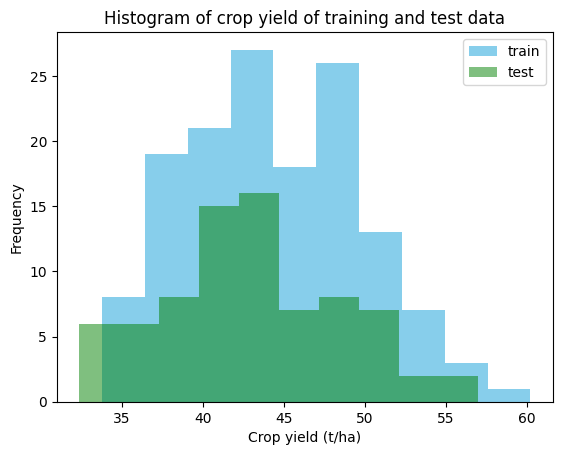

In [5]:
# TODO: create a matplotlib figure, add a histogram of the yield for training and testing data (e.g., with seaborn sns.histplot). Add nice axis descriptions.
plt.hist(train.YIELD, color='skyblue')
plt.hist(test.YIELD, color='green', alpha=0.5)

plt.xlabel('Crop yield (t/ha)')
plt.ylabel('Frequency')
plt.title('Histogram of crop yield of training and test data')
plt.legend(["train","test"])
plt.show()



<Axes: xlabel='YIELD', ylabel='Count'>

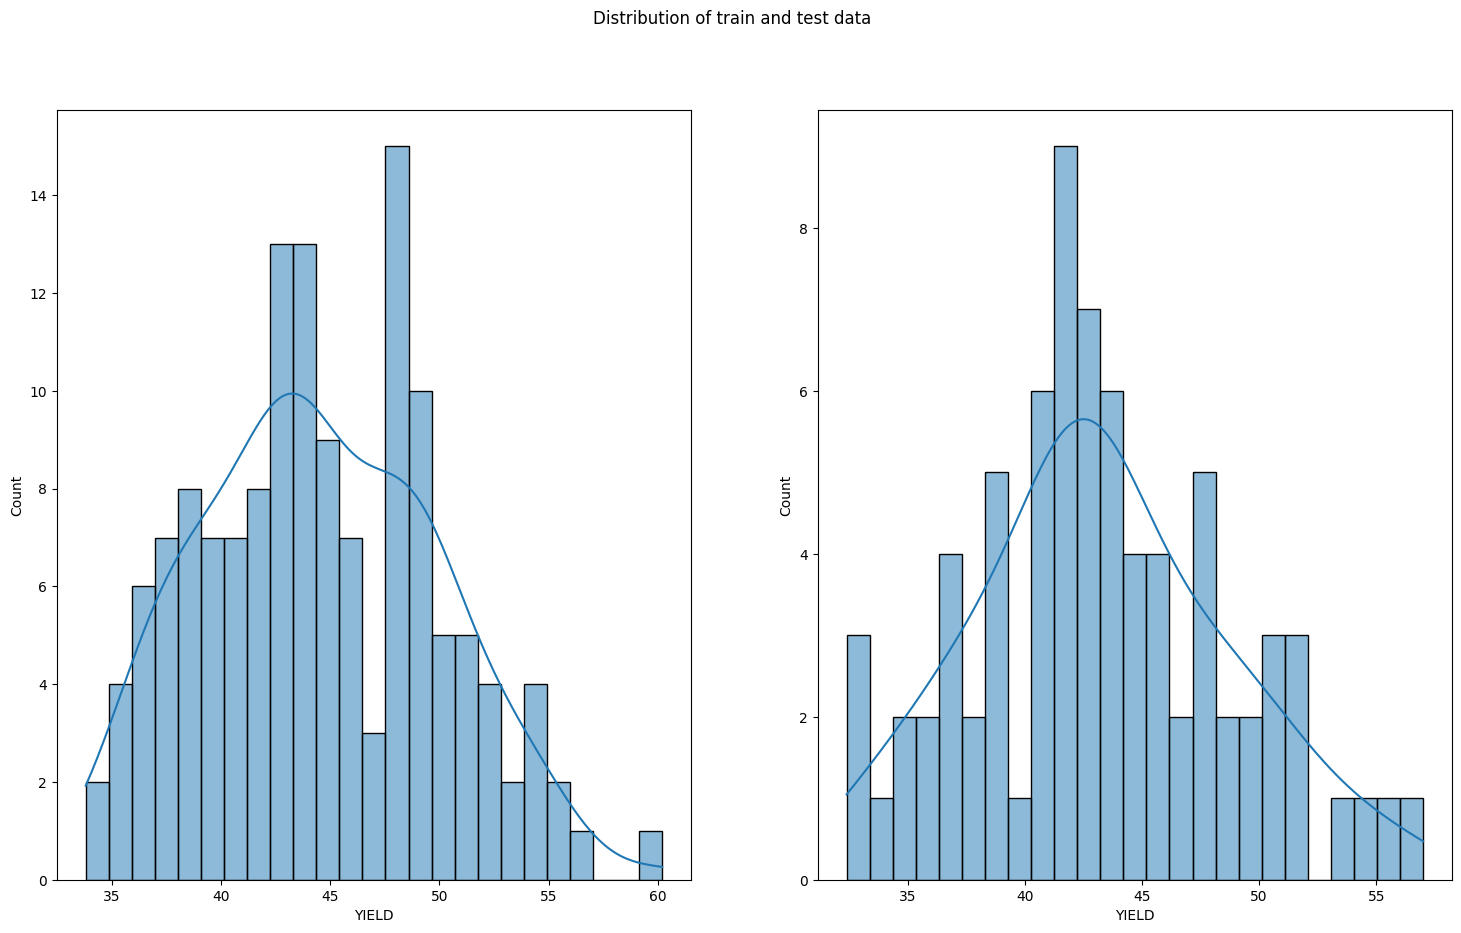

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

fig.suptitle('Distribution of train and test data')
sns.histplot(data=train, ax=axes[0], x='YIELD', bins=25, kde=True)
sns.histplot(data=test, ax=axes[1], x='YIELD', bins=25, kde=True)

TODO: Your comment here. What are min max values of the histogram? What are the extreme values? What type of distribution does the data follow?



**------------------------------------Answer Start-----------------------------------------**

Looking at the histogram, we can retrieve the following informations:

Train (left histogram):
- Min yield production: 34.5 t/ha
- Max yield production: 59.5 t/ha
- Min count: 1
- Max count: 15

The extreme value of the train data is 59.9 t/ha.

Test(right histogram):
- Min yield production: 33.5 t/ha
- Max yield production: 56.5 t/ha
- Min count: 1
- Max count: 9

The test data contains one extreme count on 33.5t/ha.

Distribution:
- Both data sets are more less normal distributed

**------------------------------------Answer End-----------------------------------------**

> ## Question 1.2
> Calculate summary statistics for potato yields, in both training and test split.
>    - Interprete the summary statistics.
>    - e.g., how many samples are in train and test set?
>    - what is the mean, std, 25%, 50%, 75% quantiles of the data?
> Hint: Use the pandas describe function


In [7]:
# TODO: Your code here. Print the statistics
test['YIELD'].describe()

count    77.000000
mean     43.232468
std       5.426529
min      32.400000
25%      39.400000
50%      42.700000
75%      46.400000
max      57.000000
Name: YIELD, dtype: float64

In [8]:
train['YIELD'].describe()

count    143.000000
mean      44.497902
std        5.386753
min       33.800000
25%       40.550000
50%       44.000000
75%       48.300000
max       60.200000
Name: YIELD, dtype: float64

TODO: Add your interpretation of the summary statistics. Are the statistics similar between training and test?



**------------------------------------Answer Start-----------------------------------------**

Generall:

- the statisitcs are very similar
- The mean shows the average yield per hecta accross all observations in the data set
- The minimum shows the loserst observated yield production in the data set
The maximum shows the largest observated yield production in the data set
- the 50th percintile indicate the median value


Summery statistic of potato yield:

Train:
- 143 samples
- mean: 44.49 t/ha
- std: 5.4
- min: 32.4 t/ha
- max: 57.0 t/ha
- 25% of the data is below 39.4 t/ha
- 50% of the data is below 42.7 t/ha
- 75% of the data is below 46.4 t/h

- the range of data in the second and the third quantile is more less the same (r = 4)

Train:
- 77 samples
- mean: 43.32 t/ha
- std: 5.3
- min: 33.8 t/ha
- max: 60.2 t/ha
- 25% of the data is below 40.55 t/ha
- 50% of the data is below 44 t/ha
- 75% of the data is below 48.4 t/h

- the range of data in the second and the third quantile is more less the same (r = 4)




**-------------------------------------Answer End------------------------------------------**

> ## Question 1.3
>
> Plot a boxplot diagram of yields as a function of year for both training and test data.
>  - What do you derive from this plot?




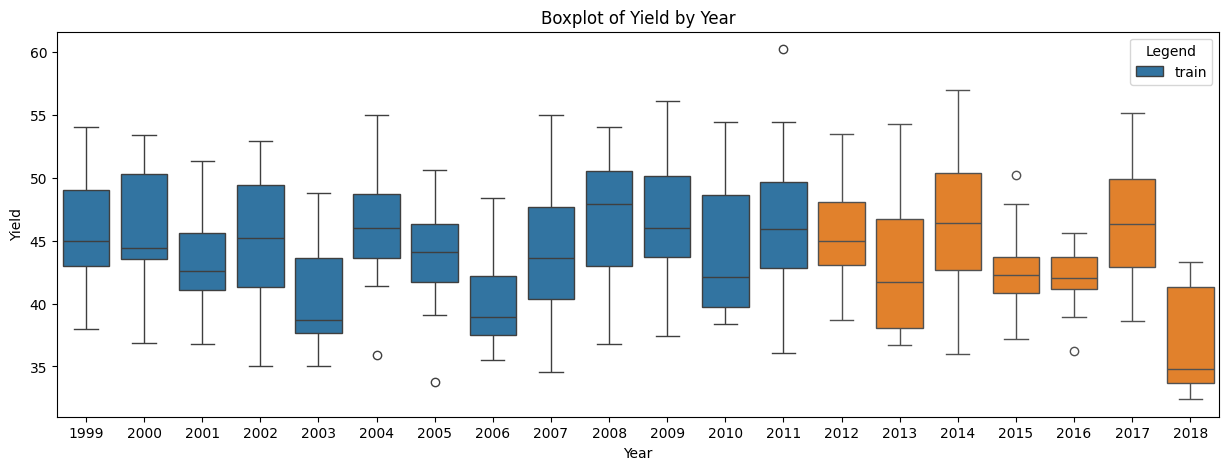

In [9]:
# TODO: Your code here. combine training and test data, and produce boxplots grouped by year.


plt.figure(figsize=(15,5))
#sns.boxplot(data=train[["FYEAR", "YIELD"]], orient='h')
sns.boxplot(x='FYEAR', y='YIELD', data=train)
sns.boxplot(x='FYEAR', y='YIELD', data=test)
# Add labels and title
plt.xlabel('Year')
plt.ylabel('Yield')
plt.title('Boxplot of Yield by Year')

# Add legend
plt.legend(["train"], title = "Legend")


plt.show()


**------------------------------------Answer Start-----------------------------------------**

Train data: blue boxplots. Test data: orange boxplots.

- we can see that most of the years have a mean around 45 t/ha.
- there are two years in the train data (2003 & 2006) with generall lower values, maybe because of dry conditions
- there is one year in the test data (2018) with a verly  low mean (less than 35 t/ha), maybe because of dry conditions
- 2015 & 2016 in the test data have a very small range for the second and third quantile, so most of the yield values are very similar
- It is possible to notice there are outliars in 2004, 2005 and 2016 (extremely low Yield values) and 2011 and 2015 (extremely high Yield values).


**-------------------------------------Answer End------------------------------------------**

> ## Question 1.4.
> Visually inspect the relationship using scatterplots, between `YIELD` and:  
>  
>   a. average FAPAR in periods p2 and p4, i.e. 'avgFAPARp2', 'avgFAPARp4'.  
>   b. average precipitation in periods p0, p3 and p5, i.e. `avgPRECp0`, `avgPRECp3`, `avgPRECp5`.
>   - Comment on the two visualizations produced in this exercise.
>

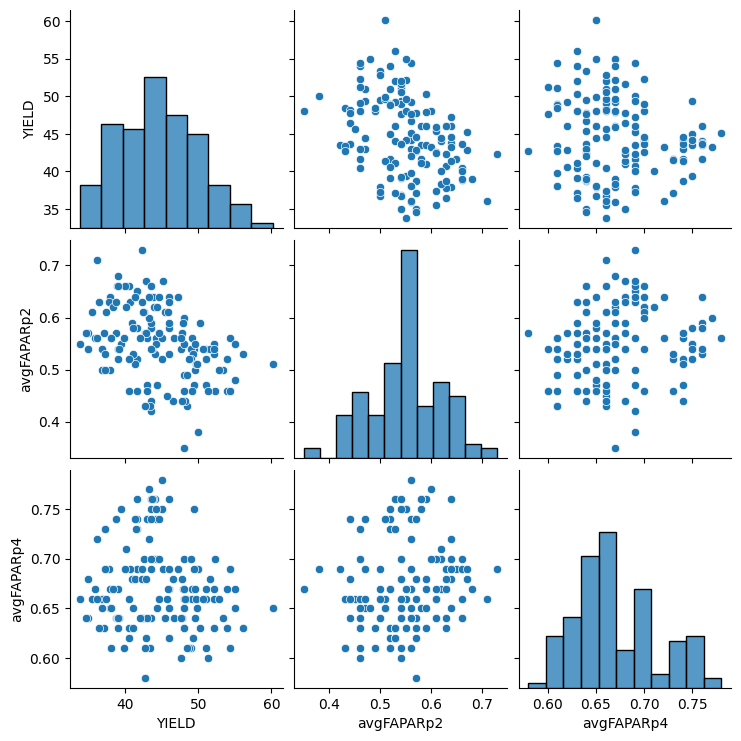

In [10]:
# TODO: Your code here. Create seaborn pairplots with yield, avgFAPARp2 and avgFAPARp4 as values
sns.pairplot(train[['YIELD', 'avgFAPARp2', 'avgFAPARp4']])
plt.show()


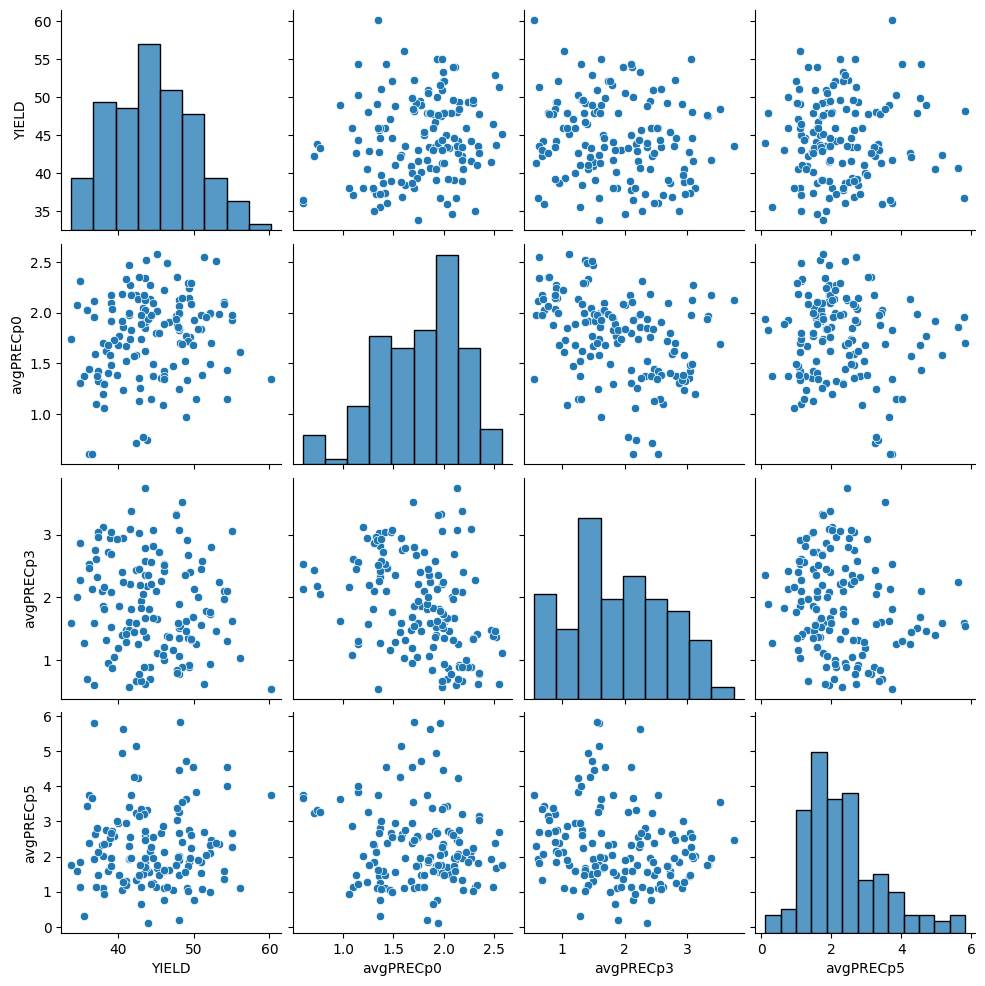

In [11]:
# b) average precipitation in periods p0, p3 and p5, i.e. avgPRECp0, avgPRECp3, avgPRECp5
sns.pairplot(train[['YIELD', 'avgPRECp0', 'avgPRECp3', 'avgPRECp5']])
plt.show()

TODO: Add your comments here.

**----------------Answer Start----------------------**

a)
- through the inspection of the plots, there is no clear correlation visible in the training data
- maybe there is a small correlation between avgFAPARp2 and yield is a small negative correlation (increasing yield, means lower avgFAPARp2)
-------------------------------------------------
b)
- thorugh the inspection of the plots, also here is no clear correlation visible in the training data

**----------------Answer End--------------------------**

> ## Question 1.5
> Calculate Pearson and Spearman correlations between the variables and Yield.
> What variables are most positively and negatively correlated with Yield?
>
> Hint: you can use the dataframe.corr() functions in pandas.




In [12]:
# we remove ID region text field because we cant calculate correlations over strings
train = train.drop(columns=["IDREGION"], errors='ignore')

# TODO: Your code here
pearson_train = (train.corr()["YIELD"]) #pearson
spearman_train = train.corr(method="spearman")["YIELD"] #spearman

# Get minimum Pearson and Spearman correlation coefficients
min_pearson_train = pearson_train.min()
min_spearman_train = spearman_train.min()

# Get maximum Pearson and Spearman correlation coefficients
# The higehst correlation is obvioulsy between yield and yield, but this does not make sense in the context so we want to get the second highest

# Sort the Series in descending order and get the second value
second_highest_pearson_train = pearson_train.sort_values(ascending=False).iloc[1]
second_highest_spearman_train = spearman_train.sort_values(ascending=False).iloc[1]

In [13]:
row_with_min_value_train_pearson = pearson_train.loc[pearson_train == min_pearson_train]
row_with_max_value_train_pearson = pearson_train.loc[pearson_train == second_highest_pearson_train]
row_with_min_value_train_spearman = spearman_train.loc[spearman_train == min_spearman_train]
row_with_max_value_train_spearman = spearman_train.loc[spearman_train == second_highest_spearman_train]

print('min value train pearson', row_with_min_value_train_pearson, 'max value train pearson', row_with_max_value_train_pearson, 'min value train spearman',  row_with_min_value_train_spearman, 'max value train spearman', row_with_max_value_train_spearman)


min value train pearson maxWLIM_YBp2   -0.414746
Name: YIELD, dtype: float64 max value train pearson avgCWBp0    0.204369
Name: YIELD, dtype: float64 min value train spearman maxWLIM_YBp2   -0.437012
Name: YIELD, dtype: float64 max value train spearman avgCWBp0    0.239848
Name: YIELD, dtype: float64


In [14]:
# we remove ID region text field because we cant calculate correlations over strings
test = test.drop(columns=["IDREGION"], errors='ignore')

# TODO: Your code here
# retrieve pearson and spearman correlations values for train and test:
pearson_test = (test.corr()["YIELD"]) #pearson
spearman_test = test.corr(method="spearman")["YIELD"] #spearman

# Exclude correlation with 'YIELD' itself (which will be 1.0)
pearson_test = pearson_test.drop('YIELD')
spearman_test = spearman_test.drop('YIELD')

pearson_test_min = pearson_test.min()
pearson_test_max = pearson_test.max()
spearman_test_min = spearman_test.min()
spearman_test_max = spearman_test.max()

row_with_min_value_test_pearson = pearson_test.loc[pearson_test == pearson_test_min]
row_with_max_value_test_pearson = pearson_test.loc[pearson_test == pearson_test_max]
row_with_min_value_test_spearman = spearman_test.loc[spearman_test == spearman_test_min]
row_with_max_value_test_spearman = spearman_test.loc[spearman_test == spearman_test_max]

In [15]:
print('min value test pearson', row_with_min_value_test_pearson, 'max value test pearson', row_with_max_value_test_pearson, 'min value test spearman',  row_with_min_value_test_spearman, 'max value test spearman', row_with_max_value_test_spearman)


min value test pearson maxTWCp2   -0.432843
Name: YIELD, dtype: float64 max value test pearson avgRSMp2    0.450967
Name: YIELD, dtype: float64 min value test spearman maxWLIM_YBp2   -0.371221
Name: YIELD, dtype: float64 max value test spearman avgRSMp2    0.482569
Name: YIELD, dtype: float64


**------------------------------------Answer Start-----------------------------------------**

Train data:

1.   Pearson
- most positiv: avgCWBp0    (0.204369)
- most negativ: maxWLIM_YBp2   (-0.414746)

2.   Spearman
- most positiv: avgCWBp0    (0.239848)
- most negativ: maxWLIM_YBp2   (-0.437012)

In the training data is both for Pearson and Spearman the most positively corraltion with yield is "avgCWBp0 ".

In the training data, the variable "maxWLIM_YBp2" is most negatively correlated with Yield using Pearson and Spearman correlation.

Test data:
1.   Pearson
- most positiv: avgRSMp2    (0.450967)
- most negativ:  maxTWCp2  (-0.432843)

2.   Spearman
- most positiv: avgRSMp2    (0.482569)
- most negativ: maxWLIM_YBp2   (-0.371221)



In the test data is both for Pearson and Spearman the most positively corraltion with yield is "avgRSMp2 ".

In the test data, the variable "maxTWCp2" is most negatively correlated with Yield using Pearson correlation.

In the test data, the variable "maxWLIM_YBp2" is most negatively correlated with Yield using Spearman correlation.

**------------------------------------Answer End-----------------------------------------**

# Exercise 2: Linear models
*See Section 3.6.2 in the book*

In this exercise, we will train a linear model with the yield data, and evaluate it using several measures.

The aim is to create a model that is independent of location and year, rather is uses weather, remote sensing and crop modelling features as predictors.

First, remove from your training and test data, the identifier columns, i.e. region name and year.

In [16]:
X_train = train.drop(columns=["IDREGION","FYEAR",'YIELD'], errors='ignore')
y_train = train['YIELD']

X_test = test.drop(columns=["IDREGION","FYEAR",'YIELD'], errors='ignore')
y_test = test['YIELD']

> ## Question 2.1
> Train a linear model with your training data, using the function `smf.ols(...).fit()`
>



Tip: use `join` to create the function formula you want, as below:

```formula = 'YIELD ~ ' + '+'.join(X_train.columns)```


In [17]:
formula = 'YIELD ~ ' + '+'.join(X_train.columns)
formula

'YIELD ~ SM_WHC+maxWLIM_YBp2+maxTWCp2+maxWLAIp2+maxWLIM_YBp4+maxWLIM_YSp4+maxTWCp4+maxWLAIp4+avgRSMp2+avgRSMp4+avgTAVGp0+avgPRECp0+avgCWBp0+avgTAVGp1+avgPRECp1+avgTAVGp2+avgCWBp2+avgPRECp3+avgCWBp4+avgPRECp5+avgFAPARp2+avgFAPARp4'

In [18]:
import statsmodels.formula.api as smf

# TODO: Your code here
lm_fit = smf.ols(formula, train).fit()


> ## Question 2.2
>  Check the coefficients of the model.
> Which are the most significant? What do the signs of the coefficients mean?
>  -  Explain below.
> Hint: use the model.summary() function


In [19]:
# TODO: Your code here
print(lm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  YIELD   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     8.761
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           3.82e-16
Time:                        18:30:23   Log-Likelihood:                -374.72
No. Observations:                 143   AIC:                             795.4
Df Residuals:                     120   BIC:                             863.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       43.2900     14.542      2.977   

TODO: Answer the two questions: Which are the most important coeffcients, and what do the signs of the coeficients mean.



**------------------------------------Answer Start-----------------------------------------**

Which are the most important coefficients?:
- The low p-values (< 0.05) indicate a significant relationship between the predictors with the dependent variable.
- In this case, for instance maxWLIM_YBp2, maxTWCp2, avgTAVGp0 and avgPRECp0 show a significant relationship with Yield.

Positive coefficient:
-  A positive coefficient indicates that there is a positive relationship between the independent variable and the dependent variable. In other words, as the independent variable increases, the dependent variable tends to increase as well.

Negative coefficient:
-  A negative coefficient indicates that there is a negative relationship between the independent variable and the dependent variable. In other words, as the independent variable increases, the dependent variable tends to decrease.

R-squared:
-  is a measure of how well the independent variables explain the variability of the dependent variable. A higher R-squared value indicates a better fit of the model to the data.

F-statistic:
-
A higher F-statistic value with a low p-value suggests that the regression model as a whole is statistically significant.

**------------------------------------Answer Start-----------------------------------------**

> ## Question 2.3
>  What is the $R^2$  reported for training?
> Hint: Check the documentation for the right member variables in the fitted function

In [20]:
# TODO: Your code here
lm_fit.rsquared

0.6163038660050204

**------------------------------------Answer Start-----------------------------------------**

R2 = 0.616
- 61.6% of of the variance in the data is explained by the model

**------------------------------------Answer Start-----------------------------------------**

> ## Question 2.4
Check the presence of collinearity in the dataset. Which independent variables are affected by collinearity? How would you solve the issue?

  -  Explain below.


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# TODO: Your code here
# Define a function to calculate the variance inflation factors for all predictors
def vif(df, dep_var):
  df_no_dep_var = df.drop(dep_var, axis=1)
  exog_df =  sm.add_constant(df_no_dep_var.values)
  vifs = pd.Series( [variance_inflation_factor(exog_df, i) for i in range(1,exog_df.shape[1])  ],
                    index=df_no_dep_var.columns, name = 'vif')
  return(vifs)

viv = vif(train, 'YIELD')

TODO: Add your inerpretation of the $\textrm{VIF}$ values.


**------------------------------------Answer Start-----------------------------------------**

In generall: VIF is a measure for collinearity in regression analysis. Those occur when independent variables are correclated with each other.
- VIF = 1: No collinearity
- VIF > 1 & < 5: moderate collinearity
- VIF > 5: high collinearity
- VIF > 10: very high collinearity

A (very) high VIF refers to a less reliable coefficent estimates

High:
- FYEAR             7.001418
- avgTAVGp0         6.560928
- avgTAVGp1         9.283420
- avgTAVGp2         5.277133
- avgCWBp2          7.087852
- avgPRECp3         5.744043

Very High:
- maxWLIM_YBp2    191.465297
- maxTWCp2        156.316011
- maxWLAIp2        46.121582
- maxWLIM_YBp4    437.581989
- maxWLIM_YSp4    356.887591
- maxTWCp4         45.638643
- maxWLAIp4        11.245406
- avgRSMp4         15.905747
- avgPRECp0        43.102012
- avgCWBp0         54.960455
- avgCWBp4         27.643508


To solve this issue, we can do a feature selection: removing the redundant or highly correlated variables from the model. We can also do a Principal Component Analysis (PCA): to decorrelate predictor variables by transforming them into a new set of uncorrelated variables (principal components).

**------------------------------------Answer End-----------------------------------------**

> ## Question 2.5
> Apply the linear model for making predictions with the test data.
> Report RMSE, MAE and R2 metrics for both training and test sets.
>  - Comment your results below.

Tip: Use scikit-learn functions from the package [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Check the documentation of MSE for reporting RMSE - see the `squared` parameter.

TODO: add your response here:

#SOLUTIONSTART
* The model performed better when predicting observations from the training set, this is a sign of overfitting.
* A negative R^2 indicates that your model fits the data extremely poorly, worse than a horizontal line.
* The predictions made by the model are further away from the actual values, compared to using the mean as a guess.
#SOLUTIONSTART

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# TODO: Your code here. return the MAE, RMSE, R2
# Apply the linear model for making predictions with the test data
y_pred_test = lm_fit.predict(test)
print("MAE-test", mean_absolute_error(y_test, y_pred_test))
print("MSE-test", mean_squared_error(y_test, y_pred_test))
print("R2-test", r2_score(y_test, y_pred_test))
print("RMSE-test", np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Apply the linear model for making predictions with the train data
y_pred_train = lm_fit.predict(train)
print("MAE-train", mean_absolute_error(y_train, y_pred_train))
print("MSE-train", mean_squared_error(y_train, y_pred_train))
print("R2-train", r2_score(y_train, y_pred_train))
print("RMSE-test", np.sqrt(mean_squared_error(y_train, y_pred_train)))

MAE-test 5.326556401906747
MSE-test 40.149746918444215
R2-test -0.3813878200212446
RMSE-test 6.336382794500677
MAE-train 2.656921910350922
MSE-train 11.055893845523467
R2-train 0.6163038660050205
RMSE-test 3.325040427652492


**------------------------------------Answer Start-----------------------------------------**

Training data:
- RMSE =  3.325
- MAE = 2.657
- R2 = 0.616

RMSE: The predicted values of our model are off by 3.325, in average, of the actual values
MAE: The predicted values of our model are off by 2.657, in average, of the actual values, doesnt matter the direction
R2: 61.6% of of the variance in the data is explained by the model

Test data:
- RMSE =  6.336
- MAE = 5.327
- R2 = -0.381

RMSE: The predicted values of our model are off by 6.336, in average, of the actual values
MAE: The predicted values of our model are off by 5.327, in average, of the actual values, doesnt matter the direction

- The negative R^2 indicates that the model fits the data extremely poorly, worse than a horizontal line.
- The model performed better when predicting observations from the training set, this is a sign of overfitting.

**------------------------------------Answer End-----------------------------------------**

> # Question 2.6
> Visualize your model predictions in the test set vs. the observed values.


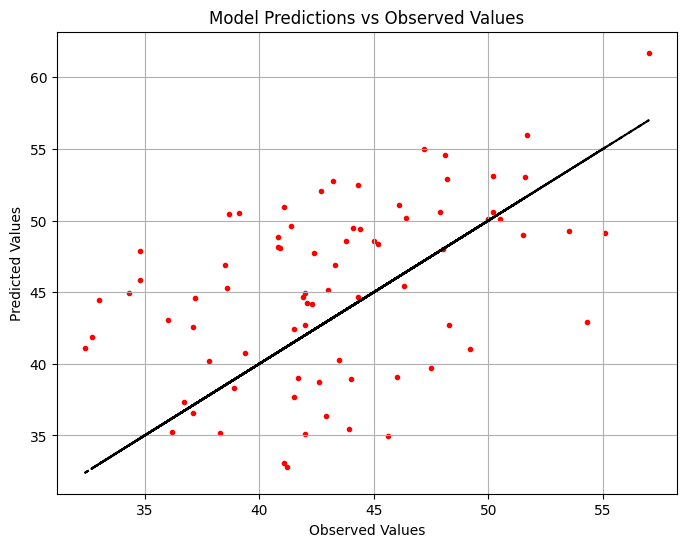

In [23]:
# TODO: Your code here. Add a matplotlib scatterplot between the ground truth yield data and the predictions
plt.figure(figsize=(8, 6))
plt.scatter(x=test['YIELD'], y=y_pred_test, marker='.', color= 'red')

# Plotting a diagonal line for reference
plt.plot(test['YIELD'], test['YIELD'], color='black', linestyle='--')

plt.title('Model Predictions vs Observed Values')
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

># Question 2.7
> Adapt your previously made model and re-run the code. How have the performance metrics changed? Suggestions for adapting the model is to include polynomials, logarithms, or to remove colinearity effects from the VIF

  * Give a brief description of the changes made, and comment your results below.



In [24]:
# TODO: Your code here

# TODO Exclude predictors that suffer from collinearity
# e.g., Cut-off = 5 and Cut-off = 10
vif5 = viv[viv < 5]
vif10 = viv[viv < 10]

In [25]:
# TODO Fit the linear model to the training data with the selected predictors (VIF < 5)
X_train5 =  X_train[X_train.columns[X_train.columns.isin(vif5.index)]]
X_train5["YIELD"] = y_train
formula5 = 'YIELD ~ ' + 'SM_WHC+avgRSMp2+avgPRECp1+avgPRECp5+avgFAPARp2+avgFAPARp4'
lm_fit_vif5 = smf.ols(formula5, data=X_train5).fit()
X_train5["YIELD"] = y_train
X_train5

<ipython-input-25-188c3bf1682a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train5["YIELD"] = y_train
<ipython-input-25-188c3bf1682a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train5["YIELD"] = y_train


,SM_WHC,avgRSMp2,avgPRECp1,avgPRECp5,avgFAPARp2,avgFAPARp4,YIELD
0,0.22,72.76,1.14,1.31,0.59,0.68,41.0
1,0.22,75.35,1.41,2.56,0.65,0.69,41.6
2,0.22,83.64,1.20,5.62,0.63,0.69,40.7
3,0.22,67.42,1.29,1.06,0.66,0.66,40.5
4,0.22,90.24,3.26,2.02,0.64,0.65,38.0
...,...,...,...,...,...,...,...
138,0.16,107.42,1.02,2.26,0.55,0.67,55.0
139,0.16,81.95,1.32,1.35,0.52,0.67,54.0
140,0.16,85.81,1.30,1.10,0.53,0.63,56.1
141,0.16,99.26,0.61,4.55,0.46,0.61,54.4


In [26]:
# Fit the linear model to the training data with the selected predictors (VIF < 10)
X_train10 =  X_train[X_train.columns[X_train.columns.isin(vif10.index)]]
X_train10["YIELD"] = y_train
formula10 = 'YIELD ~ '  +  'SM_WHC+avgRSMp2+avgTAVGp0+avgTAVGp1+avgPRECp1+avgTAVGp2+avgCWBp2+avgPRECp3+avgPRECp5+avgFAPARp2+avgFAPARp4'
lm_fit_vif10 = smf.ols(formula10, data=X_train10).fit()
X_train10

<ipython-input-26-1fac118c2651>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train10["YIELD"] = y_train


,SM_WHC,avgRSMp2,avgTAVGp0,avgTAVGp1,avgPRECp1,avgTAVGp2,avgCWBp2,avgPRECp3,avgPRECp5,avgFAPARp2,avgFAPARp4,YIELD
0,0.22,72.76,6.91,12.90,1.14,13.79,-1.32,1.49,1.31,0.59,0.68,41.0
1,0.22,75.35,7.12,14.46,1.41,13.81,-1.26,2.21,2.56,0.65,0.69,41.6
2,0.22,83.64,5.90,12.49,1.20,12.89,-1.24,2.25,5.62,0.63,0.69,40.7
3,0.22,67.42,8.10,13.28,1.29,14.93,-1.59,2.40,1.06,0.66,0.66,40.5
4,0.22,90.24,5.77,12.33,3.26,12.93,0.04,3.13,2.02,0.64,0.65,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.16,107.42,8.69,14.91,1.02,15.01,-1.13,3.06,2.26,0.55,0.67,55.0
139,0.16,81.95,6.86,11.97,1.32,14.64,-1.87,1.98,1.35,0.52,0.67,54.0
140,0.16,85.81,5.66,12.73,1.30,13.21,-1.76,1.03,1.10,0.53,0.63,56.1
141,0.16,99.26,4.55,9.90,0.61,10.24,-1.20,2.10,4.55,0.46,0.61,54.4


In [27]:
#TODO print the summary of R^2 and adj-R^2 for the 3 models lm_fit, 5-VIF cutoff and 10VIF cutoff
y_pred_train = lm_fit.predict(train)

def adjusted_r_squared(r_squared, n, p):

    adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
    return adjusted_r_squared

print("R2-train", r2_score(y_train, y_pred_train))
print("Adjusted R2-train", adjusted_r_squared(r2_score(y_train, y_pred_train),len(y_train), X_train.shape[1]))

# Below 5
y_pred_train5 = lm_fit_vif5.predict(X_train)
print("R2-train VIF5 :", r2_score(y_train, y_pred_train5))
print("Adjusted R2-train VIF5", adjusted_r_squared(r2_score(y_train, y_pred_train5),len(y_train), X_train.shape[1]))

# Below 10
y_pred_train10 = lm_fit_vif10.predict(X_train)
print("R2-train VIF10 :", r2_score(y_train, y_pred_train10))
print("Adjusted R2-train VIF10", adjusted_r_squared(r2_score(y_train, y_pred_train10),len(y_train), X_train.shape[1]))

R2-train 0.6163038660050205
Adjusted R2-train 0.5459595747726076
R2-train VIF5 : 0.20691554061646722
Adjusted R2-train VIF5 0.06151672306281952
R2-train VIF10 : 0.27494274095359816
Adjusted R2-train VIF10 0.14201557679509114


TODO: Your comments here



**------------------------------------Answer Start-----------------------------------------**


We reduced colinearity effects from the VIF removing the 5 variables with the highest VIF. However, our (adjusted) R2 score decreased compared to the original dataset. The same happened with VIF 10. We did not expect that.

On the other hand, (adjusted) R2 score increased when we removed 10 colinear variables (VIF 10) when compared to VIF 5, what was expected.

**------------------------------------Answer End-----------------------------------------**

# Exercise 3: K-Nearest Neighbors for regression
*See Section 3.5 in the book*

In this assignment we will use the function `KNeighborsRegressor()` from the library sklearn. In the practical, you have used `KNeighborsClassifier()` which is used for classification, but for continous values like predicting yield we use the `KNeighborsRegressor()` function which is for regression.

> # Question 3.1
> What value for K would you guess being reasonable?
>
> Train a KNN regression model for this value, and evaluate its performance in the test set using the metrics used for the linear model.
>  - Comment the scores of the KNN model and compare to the ones previously obtained by the linear model.


In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

# Good to scale the predictors first
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TODO implement the KNeighborsRegressor with 1, 3, 5, 100 neighbors, fit it to the training data, predict with the test data and report the R2, and visualize the result in a scatterplot between predicted and ground truth
np.random.seed(1)

knn_model1 = KNeighborsRegressor(n_neighbors=1)
knn_fit1 = knn_model1.fit(X_train_scaled, y_train)

knn_model3 = KNeighborsRegressor(n_neighbors=3)
knn_fit3 = knn_model3.fit(X_train_scaled, y_train)

knn_model5 = KNeighborsRegressor(n_neighbors=5)
knn_fit5 = knn_model5.fit(X_train_scaled, y_train)

knn_model10 = KNeighborsRegressor(n_neighbors=10)
knn_fit10 = knn_model10.fit(X_train_scaled, y_train)

knn_model100 = KNeighborsRegressor(n_neighbors=100)
knn_fit100 = knn_model100.fit(X_train_scaled, y_train)


# Compare the predicted and true labels
y_pred_train1 = knn_fit1.predict(X_test_scaled)
y_pred_train3 = knn_fit3.predict(X_test_scaled)
y_pred_train5 = knn_fit5.predict(X_test_scaled)
y_pred_train10 = knn_fit10.predict(X_test_scaled)
y_pred_train100 = knn_fit100.predict(X_test_scaled)

print("R2-pred_train 1 neighbor", r2_score(y_test, y_pred_train1))
print("R2-pred_train 3 neighbors", r2_score(y_test, y_pred_train3))
print("R2-pred_train 5 neighbors", r2_score(y_test, y_pred_train5))
print("R2-pred_train 10 neighbors", r2_score(y_test, y_pred_train10))
print("R2-pred_train 100 neighbors", r2_score(y_test, y_pred_train100))



R2-pred_train 1 neighbor -0.39836712159351806
R2-pred_train 3 neighbors 0.19587723016566894
R2-pred_train 5 neighbors 0.2703679405105951
R2-pred_train 10 neighbors 0.15151712396693784
R2-pred_train 100 neighbors -0.06898607119077371


In [29]:
X_train.shape

(143, 22)

TODO: Add here your guess for K! How does this compare with the linear model

**------------------------------------Answer Start-----------------------------------------**

Guess of K:
- Without knowing the noise level of the data, we assume that one of the moste often useed values for K (5 or 10) would be reasonable


- Considering the values for k=1, 3, 5, 10 or 100, the value k = 5 is the more reasonable, because it gives us the highest value for R2: 0.27.

- The R2 score for the predictions made with linear model based on the training data was 0.61, and -0.38 for the predictions made with the test data.

- So the KNN model performs better when compared to the predictions of the test data.

**------------------------------------Answer End-----------------------------------------**

> ## Question 3.2
>  We will now tune the (hyper)parameter of the model (K).
>
> This means you will loop (use for()) the KNN with different values of K and retain the one that gives the best performances (cross-validation, chapter 5.1).
>
> We will use the ‘validation set approach’ (chapter 5.1.1, take a moment to read it), i.e. we will sacrifice part of our training samples to find K.

> Run the KNN by using as training samples the first 110 samples of the training set and the remaining 33 samples of the training set as validation set.   **Do not use the test set here, otherwise you will bias your final results!** Pick the best k, based on the performance on the validation set.   
>
>   - 2a. What range of values would be suitable for K in this problem?  
>   
>   - 2b. Report your best k, your metrics ($RMSE$, $MAE$, $R^2$) and comment.  


In [30]:
# Let's split training data into training and validation.
X_train110 = X_train_scaled[:110]
y_train110 = y_train[:110]

X_validation = X_train_scaled[110:]
y_validation = y_train[110:]


In [31]:
# TODO Fit a K-Neighbor regression model to the training data for different Ks between 1 and 101
# Compute regression performance metrics (RMSE, MAE and  R^2) for the validation set.
# print the results and find the best K parameter

#### CHAT GPT CODE BELOW:

# Function to fit K-Neighbor regression models for different Ks and compute performance metrics
def knn_regression(X_train, y_train, X_validation, y_validation, k_values):
    results = {}
    for k in k_values:
        knn_model = KNeighborsRegressor(n_neighbors=k)
        knn_fit = knn_model.fit(X_train, y_train)
        y_pred = knn_fit.predict(X_validation)

        rmse = np.sqrt(mean_squared_error(y_validation, y_pred))
        mae = mean_absolute_error(y_validation, y_pred)
        r2 = r2_score(y_validation, y_pred)

        results[k] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}

    return results

# Set the range of K values
k_values = list(range(1, 102))

# Call the function to fit KNeighbor regression models and compute performance metrics
results = knn_regression(X_train110, y_train110, X_validation, y_validation, k_values)


# Print the results and find the best K parameter
best_k = None
best_r2 = -float('inf')
for k, metrics in results.items():
    print(f"K={k}: RMSE={metrics['RMSE']}, MAE={metrics['MAE']}, R2={metrics['R2']}")
    if metrics['R2'] > best_r2:
        best_k = k
        best_r2 = metrics['R2']

print(f"Best K parameter: {best_k} with R2={best_r2}")

K=1: RMSE=6.417376977607539, MAE=4.742424242424241, R2=-1.1962152886940527
K=2: RMSE=6.123006787617675, MAE=4.912121212121212, R2=-0.9993521241806063
K=3: RMSE=5.849066805190592, MAE=4.793939393939394, R2=-0.8244542188974715
K=4: RMSE=6.479190173395923, MAE=5.334090909090908, R2=-1.238727640204147
K=5: RMSE=6.52084582727044, MAE=5.461818181818183, R2=-1.2676063853230426
K=6: RMSE=6.485201361587525, MAE=5.552020202020201, R2=-1.2428836089213267
K=7: RMSE=6.439579319969732, MAE=5.581385281385282, R2=-1.2114381667905625
K=8: RMSE=6.535795594495769, MAE=5.656439393939395, R2=-1.2780157857293966
K=9: RMSE=6.660452491006953, MAE=5.7659932659932664, R2=-1.3657414344853196
K=10: RMSE=6.6446104840576234, MAE=5.781212121212121, R2=-1.3545009005620803
K=11: RMSE=6.678005696324333, MAE=5.821763085399449, R2=-1.3782273925262025
K=12: RMSE=6.756489585217423, MAE=5.865656565656566, R2=-1.434456562937977
K=13: RMSE=6.734058204084773, MAE=5.834731934731935, R2=-1.418318722913138
K=14: RMSE=6.6630486085

In [32]:
## CHECKING THE CHAT GPT CODE VALUES ABOVE WITH THE CODE FROM THE LAB 4 TUTORIAL:

# TODO implement the KNeighborsRegressor with 1, 3, 5, 100 neighbors, fit it to the training data, predict with the test data and report the R2, and visualize the result in a scatterplot between predicted and ground truth


np.random.seed(1)

knn_model1 = KNeighborsRegressor(n_neighbors=1)
knn_fit1 = knn_model1.fit(X_train110, y_train110)

knn_model3 = KNeighborsRegressor(n_neighbors=3)
knn_fit3 = knn_model3.fit(X_train110, y_train110)

knn_model5 = KNeighborsRegressor(n_neighbors=5)
knn_fit5 = knn_model5.fit(X_train110, y_train110)

knn_model100 = KNeighborsRegressor(n_neighbors=100)
knn_fit100 = knn_model100.fit(X_train110, y_train110)


# Compare the predicted and true labels
y_pred_train1 = knn_fit1.predict(X_validation)
y_pred_train3 = knn_fit3.predict(X_validation)
y_pred_train5 = knn_fit5.predict(X_validation)
y_pred_train100 = knn_fit100.predict(X_validation)

print("R2-pred_train1", r2_score(y_validation, y_pred_train1))
print("R2-pred_train3", r2_score(y_validation, y_pred_train3))
print("R2-pred_train5", r2_score(y_validation, y_pred_train5))
print("R2-pred_train100", r2_score(y_validation, y_pred_train100))



R2-pred_train1 -1.1962152886940527
R2-pred_train3 -0.8244542188974715
R2-pred_train5 -1.2676063853230426
R2-pred_train100 -2.7190268914007323


**------------------------------------Answer Start-----------------------------------------**

**2a. What range of values would be suitable for K in this problem?**

Actually all the K values show a negative R2, indicating the KNN model is not aproprieate.

**2b. Report your best k, your metrics ( RMSE ,  MAE ,  R2 ) and comment.**

the best parameter is K = 3:
RMSE=5.849066805190592, MAE=4.793939393939394, R2=-0.8244542188974715
However, when the R2 values are negative, it typically indicates that the chosen model performs worse than a simple horizontal line (a horizontal line would have an R2 score of 0).

**------------------------------------Answer End-----------------------------------------**

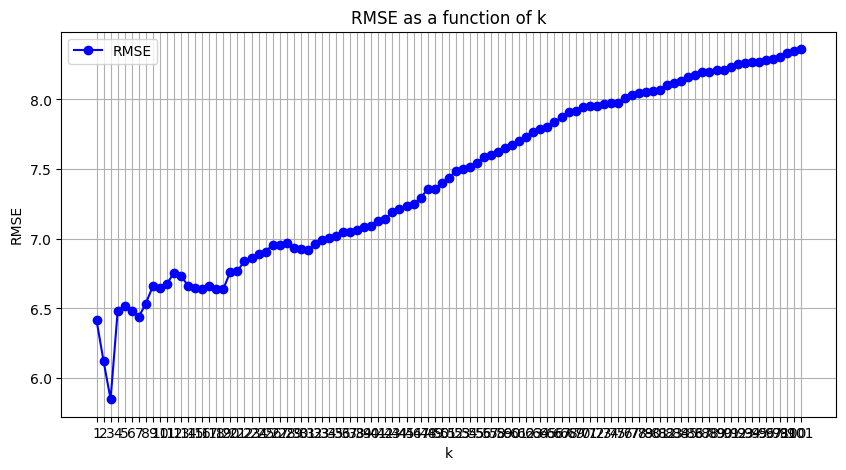

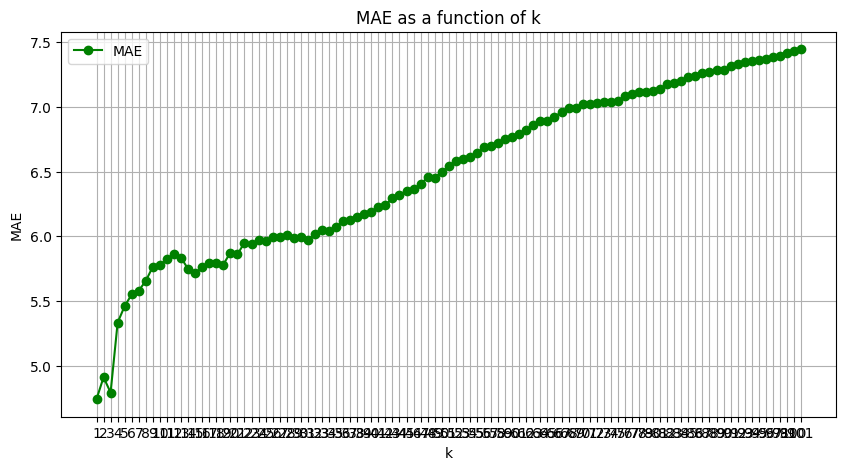

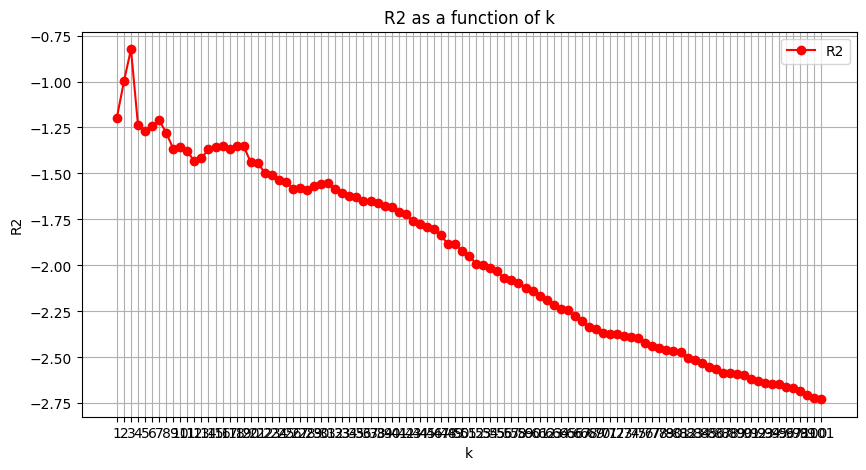

In [33]:
# TODO  Plot the accuracy, RMSE, and MAE as a function of k

# Extract metrics for plotting
ks = list(results.keys())
rmse_values = [results[k]['RMSE'] for k in ks]
mae_values = [results[k]['MAE'] for k in ks]
r2_values = [results[k]['R2'] for k in ks]

# Plot RMSE as a function of k
plt.figure(figsize=(10, 5))
plt.plot(ks, rmse_values, marker='o', linestyle='-', color='blue', label='RMSE')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('RMSE as a function of k')
plt.xticks(ks)
plt.grid(True)
plt.legend()
plt.show()

# Plot MAE as a function of k
plt.figure(figsize=(10, 5))
plt.plot(ks, mae_values, marker='o', linestyle='-', color='green', label='MAE')
plt.xlabel('k')
plt.ylabel('MAE')
plt.title('MAE as a function of k')
plt.xticks(ks)
plt.grid(True)
plt.legend()
plt.show()

# Plot R2 as a function of k
plt.figure(figsize=(10, 5))
plt.plot(ks, r2_values, marker='o', linestyle='-', color='red', label='R2')
plt.xlabel('k')
plt.ylabel('R2')
plt.title('R2 as a function of k')
plt.xticks(ks)
plt.grid(True)
plt.legend()
plt.show()



> ## Question 3.3
> Once you identified a good value for k, train your model using the full training set and evaluate its performance for the test set.
>
> ### Question 3a
> - Report the evaluation metrics, and compare with linear regression.


In [34]:
# Using k = 3 and full training set:

# Good to scale the predictors first
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TODO implement the KNeighborsRegressor with neighbors, fit it to the training data, predict with the test data and report the R2, and visualize the result in a scatterplot between predicted and ground truth
np.random.seed(1)

knn_model3 = KNeighborsRegressor(n_neighbors=3)
knn_fit3 = knn_model3.fit(X_train_scaled, y_train)

# Compare the predicted and true labels
y_pred_train3 = knn_fit3.predict(X_test_scaled)

print("R2-pred_train 3 neighbors", r2_score(y_test, y_pred_train3))

R2-pred_train 3 neighbors 0.19587723016566894


In [35]:
# TODO: Your code here. fit the training data with the best K value and predict the test data.

#CHAT GPT

from sklearn.linear_model import LinearRegression

# Train linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predict on the test set
y_pred_test_linear = linear_model.predict(X_test)

# Evaluate performance metrics
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_test_linear))
mae_linear = mean_absolute_error(y_test, y_pred_test_linear)
r2_linear = r2_score(y_test, y_pred_test_linear)

print('Linear Regression Metrics:')
print('RMSE: ', rmse_linear)
print('MAE: ', mae_linear)
print('R2 Score: ', r2_linear)

Linear Regression Metrics:
RMSE:  6.336382794470906
MAE:  5.326556401876503
R2 Score:  -0.38138782000826366


**------------------------------------Answer Start-----------------------------------------**

For the full training set, R2 = 0.19587723016566894 for kNN model, k = 3.

Using Linear Regression, R2 = -0.38138782000826366, a negative value.  

Therefore, kNN model with k = 3 shows a better performance than linear regression.

**------------------------------------Answer End-----------------------------------------**

> Question 3b
> - Make a scatter plot of the predictions of the KNN and linear model against the observed yields.


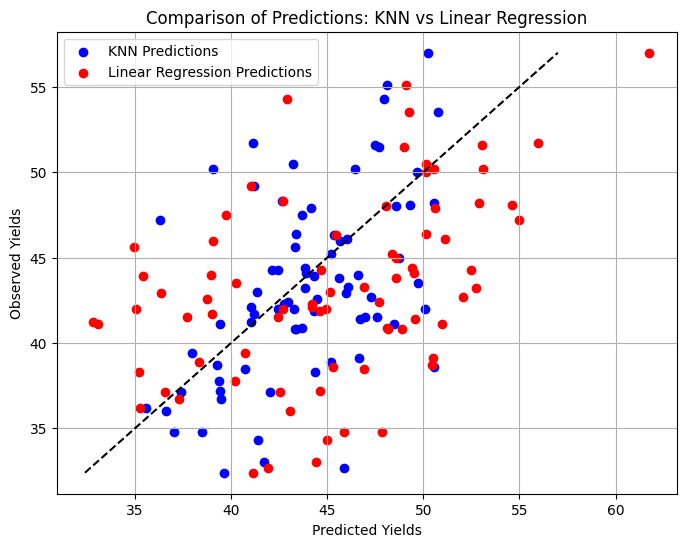

In [36]:
# TODO: Your code here. Add the scatter plot between KNN regressor and Linear regressor from earlier. Which one is better?

# CHAT GPT

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Scatter plot for KNN predictions
plt.scatter(y_pred_train3, y_test, color='blue', label='KNN Predictions')

# Scatter plot for linear regression predictions
plt.scatter(y_pred_test_linear, y_test, color='red', label='Linear Regression Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')
plt.xlabel('Predicted Yields')
plt.ylabel('Observed Yields')
plt.title('Comparison of Predictions: KNN vs Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

**------------------------------------Answer Start-----------------------------------------**

KNN model looks slightely better by looking the scatterplot, because the points look more densely distributed along the dashed line.

**------------------------------------Answer End-----------------------------------------**

# Exercise 4: Spatial visualization of errors (Optional, no fields to fill)


Since it is ptional, we decided not to answer it.

> ## Question 4.1.
> - For both the linear and the KNN models, visualize in a map their errors for year 2012.
 > -  Comment on your visualizations
   

### References

D. Paudel, H. Boogaard, A. de Wit, S. Janssen, S. Osinga, C. Pylianidis, and I. N. Athanasiadis. [Machine learning for large-scale crop yield forecasting](http://dx.doi.org/10.1016/j.agsy.2020.103016). Agricultural Systems, 187:103016, 2021.